#Welcome to learn an easy way to deploy your Computer Vision Model

Great to have you in this tutorial that will teach you an accessible method for a model deployment as the web application.

The tutorial is designed by unpackAI team, however underlying libraries are developed by open-source communities. As always, big thanks to [fast.ai](https://www.fast.ai/) team, especially to Jeremy Howard, whose mission is to make Deep Learning as accessible as possible for coders. 

At unpackAI we take even more dramatic mission on helping non-coders and business professionals to become equipped with AI/ML skills in order to become effective communicators and collaborators with software & AI developers.

![unpackai](https://unpackai.github.io/unpackai_logo.svg)

## The Content

The tutorial consists of two parts:

1. Quick model building inspired by fast.ai and optimized by unpackAI
2. Easy-to-deploy method with `streamlit`, `ngrok` by unpackAI

## Quick model building inspired by fast.ai and optimized by unpackAI

The goal is here to demostrate the quick way of model building and exporting it for the deploment.

We will use [unpackAI](https://github.com/unpackAI/unpackai) and [fastbook](https://github.com/fastai/fastbook) libraries.

In [1]:
!pip install -Uqq unpackai
!pip install -Uqq fastbook

     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 189 kB 9.0 MB/s 
     |████████████████████████████████| 91 kB 8.8 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 720 kB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.3 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 51 kB 271 kB/s 


In [2]:
from unpackai.utils import clean_error_img
from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

In [3]:
#@title Download the Dataset
path = Path("/content/bears")
path.mkdir(exist_ok=True, parents=True)
for t in ['black', 'grizzly','teddy']:
    path2class = untar_data(f"https://github.com/vtecftwy/unpackai-image-set/blob/main/{t}.zip?raw=true", data=path)
    assert path2class.is_dir(), f"Problem downloading {t}"

In [4]:
path.ls()

(#3) [Path('/content/bears/grizzly'),Path('/content/bears/black'),Path('/content/bears/teddy')]

In [5]:
clean_error_img(path)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

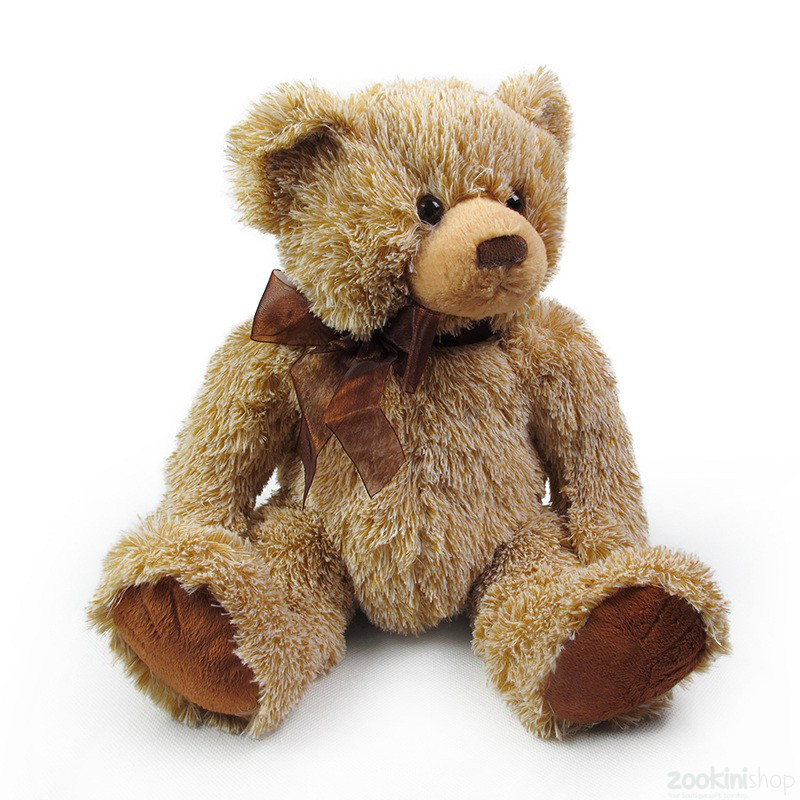

In [6]:
im = Image.open("/content/bears/teddy/00000001.jpg")
im

In [7]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(250, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [8]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.094666,0.097922,0.962963,01:36


epoch,train_loss,valid_loss,accuracy,time
0,0.125751,0.018309,1.000000,02:09


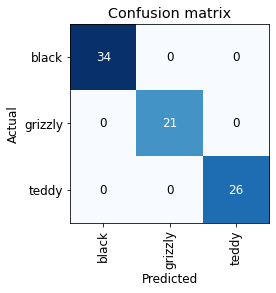

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

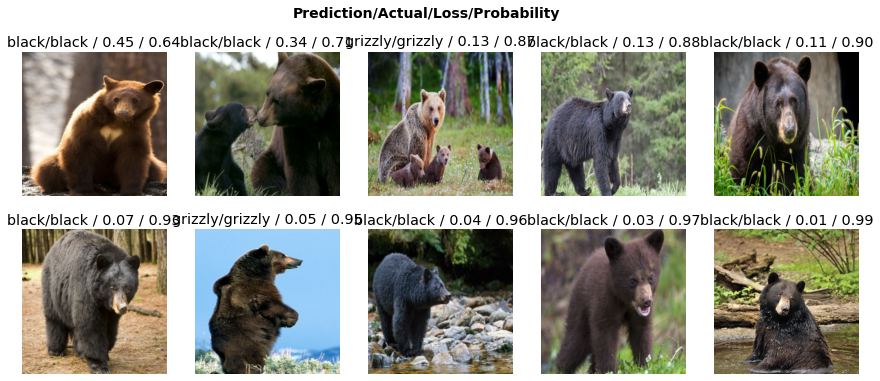

In [10]:
#@title Getting a visual result for the top losses
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

plot_top_losses_fix(interp, 10, nrows=2)

### Saving the model to a pickle

An essential part for deployment is to save the model to an external file (usually a pickle, with `.pkl` extension).

This is mandatory because our app will not be able to access the code of this notebook.

With `fastai` and `pytorch`, this is done with the `export` method:



In [11]:
learn.export('model.pkl')

Please open "Files" icon on the left panel of your Google Colab notebook. You can see that model was exported as `model.pkl` file.

## Easy-to-deploy method with Streamlit and ngrok by unpackAI

The deployment method will require you to import deployment functionality of unpackai library that packages [Steamlit](https://streamlit.io/) and [ngrok](https://ngrok.com/) as easy-to-delpoy method on Google Colab. Please run the next cell to import `unpackai[deploy]`.

Big kudos to [Jean-Francois THUONG](https://www.linkedin.com/in/jfthuong/) for developing this method. 

In [12]:
!pip install -qU  unpackai[deploy]

     |████████████████████████████████| 745 kB 4.2 MB/s 
     |████████████████████████████████| 155 kB 52.1 MB/s 
     |████████████████████████████████| 9.1 MB 17.1 MB/s 
     |████████████████████████████████| 749 kB 56.2 MB/s 
     |████████████████████████████████| 843 kB 16.2 MB/s 
     |████████████████████████████████| 4.3 MB 20.4 MB/s 
     |████████████████████████████████| 111 kB 69.9 MB/s 
     |████████████████████████████████| 178 kB 64.4 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
     |████████████████████████████████| 180 kB 45.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 125 kB 68.0 MB/s 
     |████████████████████████████████| 790 kB 71.4 MB/s 
     |████████████████████████████████| 374 kB 39.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.

In [13]:
from unpackai.deploy.app import deploy_app, StreamlitApp

Let's create the base template, that will serve as the foundation for our Streamlit application. 

There are three types of models you can potenitally launch:

* CV model built with [fast.ai](https://github.com/fastai/fastai) 
* NLP model built with [Hugging Face](https://huggingface.co/) 
* Tabular model built [PyCaret](https://pycaret.org/)

There are also templates in case if you dealing with CSV files, or creating your fully-customizable app.

### Solution #1: Hand-written app

The first way to deploy an app is to write it from scratch and use `unpackai` to deploy it online.

The documentation of the blocks of Streamlit is described here: https://docs.streamlit.io/library/api-reference

It provides clear visualization and interactive examples.

For example, the code below provides a basic app with a title and a cool icon in your browser.

You can find more templates in `unpackai` library: https://github.com/unpackAI/unpackai/tree/main/examples/deploy

The magic `%%writefile` will create a file with the content in the cell.

In [14]:
%%writefile app.py
import streamlit as st

st.set_page_config(page_title="ML deployment, by unpackAI", page_icon="🚀")
st.image("https://unpackai.github.io/unpackai_logo.svg")
st.title("Image Classification for Bear")
st.write("*by Jeff*")
st.write("---")

Writing app.py


Once you have generated the file, you can deploy it. You should be able to see the following message with an external link:

```python
Tunnel created for port 8501 to: https://c8b0-35-205-50-145.ngrok.io
... click on the link to launch the app
... Note: the output of streamlit is stored in nohup.out
```
> In case if you don't see it, re-run the cell below one more time!

In [18]:
deploy_app()

Tunnel created for port 8501 to: https://c8b0-35-205-50-145.ngrok.io
... click on the link to launch the app
... Note: the output of streamlit is stored in nohup.out



KeyboardInterrupt



Your app is deployed on the web: you will see a link that you can click on open it in your browsesr.

In case you are not able to see the link after the cell execution, simply run it again by pressing the play button one more time. 

*Note: if you have saved your app in a different location (e.g. `%%writefile my_super_cool_app.py`) then you need to put the path when deploying: `deploy_app("my_super_cool_app.py")`.*

Another cool feature of Streamlit is that you can edit the app and see the modifications live without having to reload the app.

To do so in Google Colab, just go to the file explorer and double click on the file to open / edit it on the right-hand side.

### Solution #2: using unpackai Templating system

The library `unpackai` provides a class `StreamlitApp` that automatically generates and saves templates, and can deploy them.

Let's take the example of an app to show image classification model (in our case it's Bear Classifier application).

We should provide:

* title
* author
* path to model that you exported earlier or the path in your Colab session to any other uploaded model

You then need to save it; by default, it is saved in *app.py* but you can change the destination (e.g. `app.save("my_other_super_app.py")`)

In [14]:
app = StreamlitApp("CV").render_fastai(
    title="Bears Classifier",
    author="unpackAI",
    model="/content/model.pkl"
)
app.save()

Saved app 'Bears Classifier' to 'app.py'


StreamlitApp(application='CV', framework='fastai', content='from pathlib import Path\n\nimport streamlit as st\n\n\nfrom unpackai.deploy.cv import get_image, get_learner\n\n\nst.set_page_config(page_title="ML deployment, by unpackAI", page_icon="🚀")\nst.image("https://unpackai.github.io/unpackai_logo.svg")\nst.title("Bears Classifier")\nst.write("*by unpackAI*")\nst.write("---")\n\nlearn = get_learner(Path(__file__).parent / "/content/model.pkl")\nvocab = learn.dls.vocab\n\n\ndef display_prediction(pic):\n    img = get_image(pic)\n    with learn.no_bar():\n        prediction, idx, probabilities = learn.predict(img)\n    col_img, col_pred = st.columns(2)\n    col_img.image(img, caption=getattr(pic, "name", None))\n    col_pred.write(f"### {prediction}")\n    col_pred.metric(f"Probability", f"{probabilities[idx].item()*100:.2f}%")\n\n\nselect = st.sidebar.radio("How to load images?", ["from files", "from URL"])\nst.sidebar.write("---")\n\nif select == "from URL":\n    url = st.sidebar.te

You can now deploy like you did before. You should be able to see the following message with an external link:

```python
Tunnel created for port 8501 to: https://c8b0-35-205-50-145.ngrok.io
... click on the link to launch the app
... Note: the output of streamlit is stored in nohup.out
```
> In case if you don't see it, re-run the cell below one more time!

In [ ]:
deploy_app()

Tunnel created for port 8501 to: https://4549-35-229-184-241.ngrok.io
... click on the link to launch the app
... Note: the output of streamlit is stored in nohup.out


💡**TIP**: you can also directly deploy after saving:
```python
StreamlitApp("CV").render_fastai(
    ...
).save().deploy()
```

--- END ---